Classifying flower images by fine-tuning the EfficientNet model

In [387]:
#Import file handling 
import cv2, tfrecord

# Import Torch 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# TorchVision imports 
import torchvision
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import timm # pytorch image model library 
import os, pandas as pd, numpy as np 

from tqdm import tqdm

In [388]:
# Establish EfficientNet model and required transformations
dataSetPath = "./kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224"
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [389]:
# Transform the images in a consistent format, to match EfficientNet model
"""
- Adding in a bunch of different data augmentation to prevent overfitting on training data 
- Using a mixture of random rotations/flips + blurring/cropping 
    - I also incorperated cutmix as part of the data loader step 
        -https://openaccess.thecvf.com/content_ICCV_2019/papers/Yun_CutMix_Regularization_Strategy_to_Train_Strong_Classifiers_With_Localizable_Features_ICCV_2019_paper.pdf
"""
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [390]:
# Prepare data for training

# for dirname, _, filenames in os.walk('kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [391]:
FLOWER_NAMES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

def transform_tf_to_df(subset_data):
    df = pd.DataFrame( {"id": pd.Series(dtype="str"),
                        "class": pd.Series(dtype="int"),
                        "img": pd.Series(dtype="object")})
    tf_files = []
    for subdir, dirs, files in os.walk(dataSetPath):
        if subdir.split(os.path.sep)[-1] == subset_data:
            for file in files:
                filepath = subdir + os.path.sep + file
                tf_files.append(filepath)
                
    for tf_file in tf_files: 
        if subset_data == "test":  loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte", "image": "byte"}) 
        else: loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte", "image": "byte", "class":"int"})

        for record in loader: 
            id_label = record['id'].decode("utf-8")
            label = record['class'][0].item() if subset_data != "test" else None 
            img_bytes = np.frombuffer(record['image'], dtype = np.uint8)
            # print(id_label, label, img_bytes)
            img = cv2.imdecode(img_bytes , cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            df.loc[len(df.index)] = [id_label, label, img ]
    return df 

df_validation = transform_tf_to_df('val')
df_train = transform_tf_to_df('train')
df_test = transform_tf_to_df('test')

In [392]:
class FlowersDataset( Dataset ):
    def __init__(self, data, transform=  None ) -> None:
        self.data = data
        self.transform = transform
    def __getitem__(self, idx):
        # img_id = self.data.iloc[idx, 0]
        label = self.data.iloc[idx,1]
        image = Image.fromarray(self.data.iloc[idx,2])
        if self.transform: image = self.transform(image)
        y = np.zeros(len(FLOWER_NAMES), dtype = np.float32)
        y[label] = int(1)
        return image, y
    def __len__(self) -> int:
        return len(self.data)
    
train_data = FlowersDataset(df_train, transform = train_transform)
validation_data = FlowersDataset(df_validation, transform = test_transform)
test_data = FlowersDataset(df_test, transform = test_transform)


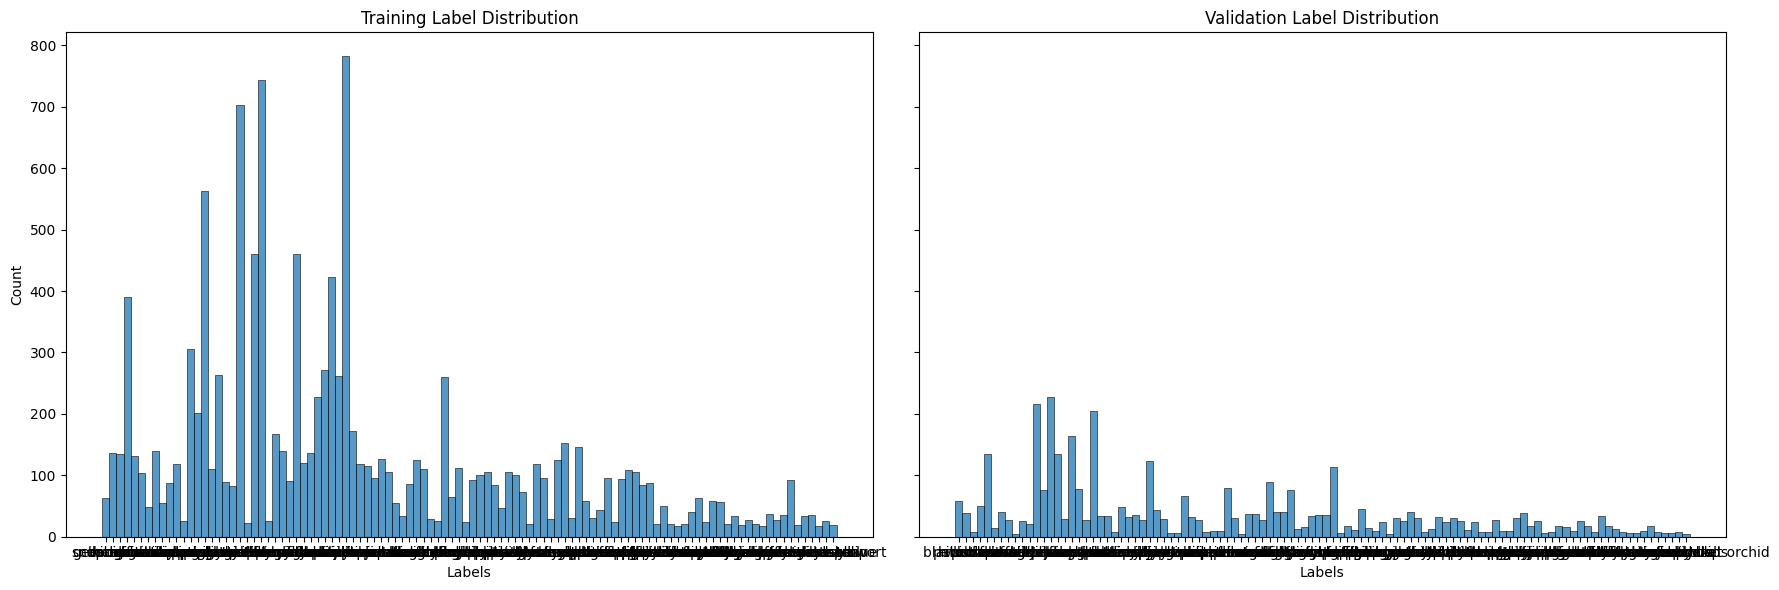

In [393]:
# Compare histograms of class frequencies from each datasets, to see distribution of data in data-sets
import seaborn as sns

train_image_distribution = [FLOWER_NAMES[label] for label in df_train['class']]
valid_image_distribution = [FLOWER_NAMES[label] for label in df_validation['class']]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
sns.histplot(train_image_distribution, discrete=True, kde=False, ax=axes[0])
axes[0].set_title('Training Label Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')

# Plot the second histogram
sns.histplot(valid_image_distribution, discrete=True, kde=False, ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Labels')

# Adjust layout
plt.tight_layout()
plt.show()

In [394]:
# Dataset is unbalanced, so I'm going to add weights for underepresented classes in the loss-function, to prevent overfitting on the majority classes.
class_counts = torch.zeros(len(FLOWER_NAMES), dtype=torch.float32)
for label in df_train['class']:
    class_counts[label] += 1
total_samples = len(train_image_distribution)
num_classes = len(FLOWER_NAMES)
class_weights = total_samples / (num_classes * class_counts)
class_weights = class_weights.float().to(device)

print(class_counts)
class_weights

tensor([272.,  26.,  20.,  21., 703.,  87.,  18., 105.,  87.,  84., 136.,  43.,
         92., 263., 227.,  21.,  55.,  50.,  90.,  26.,  19.,  96.,  48.,  19.,
         85.,  83.,  21.,  34., 119., 109., 105.,  24.,  23.,  20.,  18.,  36.,
         57.,  26.,  19.,  73.,  64.,  96.,  63., 110.,  18., 172., 125., 261.,
        422., 563., 201., 105., 115., 460.,  37.,  58.,  89.,  63.,  36.,  58.,
         27.,  29.,  93.,  28.,  55.,  33.,  21., 782., 260.,  94., 104., 137.,
        167., 460., 125., 306., 119., 139.,  86., 118., 153., 101., 134., 112.,
         31.,  29., 120., 146.,  96.,  46., 106., 111.,  24., 139., 131., 127.,
        100.,  41.,  34.,  24.,  31.,  25., 390., 743.])


tensor([0.4508, 4.7163, 6.1312, 5.8393, 0.1744, 1.4095, 6.8125, 1.1679, 1.4095,
        1.4598, 0.9017, 2.8517, 1.3329, 0.4663, 0.5402, 5.8393, 2.2295, 2.4525,
        1.3625, 4.7163, 6.4539, 1.2773, 2.5547, 6.4539, 1.4426, 1.4774, 5.8393,
        3.6066, 1.0305, 1.1250, 1.1679, 5.1094, 5.3315, 6.1312, 6.8125, 3.4063,
        2.1513, 4.7163, 6.4539, 1.6798, 1.9160, 1.2773, 1.9464, 1.1148, 6.8125,
        0.7129, 0.9810, 0.4698, 0.2906, 0.2178, 0.6101, 1.1679, 1.0663, 0.2666,
        3.3142, 2.1142, 1.3778, 1.9464, 3.4063, 2.1142, 4.5417, 4.2284, 1.3185,
        4.3795, 2.2295, 3.7159, 5.8393, 0.1568, 0.4716, 1.3045, 1.1791, 0.8951,
        0.7343, 0.2666, 0.9810, 0.4007, 1.0305, 0.8822, 1.4259, 1.0392, 0.8015,
        1.2141, 0.9151, 1.0949, 3.9556, 4.2284, 1.0219, 0.8399, 1.2773, 2.6658,
        1.1568, 1.1047, 5.1094, 0.8822, 0.9361, 0.9656, 1.2263, 2.9909, 3.6066,
        5.1094, 3.9556, 4.9050, 0.3144, 0.1650], device='cuda:0')

In [395]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size =BATCH_SIZE, shuffle = True)
validation_dataloader = DataLoader(dataset = validation_data, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f" DataLoaders, {train_dataloader, test_dataloader}")
print(f"Length of train Data Loader {len(train_dataloader)} with number of training data being {len(train_data)}")
print(f"Length of test Data Loader {len(test_dataloader)}, with number of test data being {len(test_data)}")

 DataLoaders, (<torch.utils.data.dataloader.DataLoader object at 0x0000025F272A1310>, <torch.utils.data.dataloader.DataLoader object at 0x000002617942AE50>)
Length of train Data Loader 399 with number of training data being 12753
Length of test Data Loader 231, with number of test data being 7382


In [396]:
# Applying Cutmix Data Augmentation to the batches in the data loader (splices images together)

cutmix = transforms.v2.CutMix(num_classes=len(FLOWER_NAMES))
for images, labels in train_dataloader:
    images, labels = cutmix(images, labels)

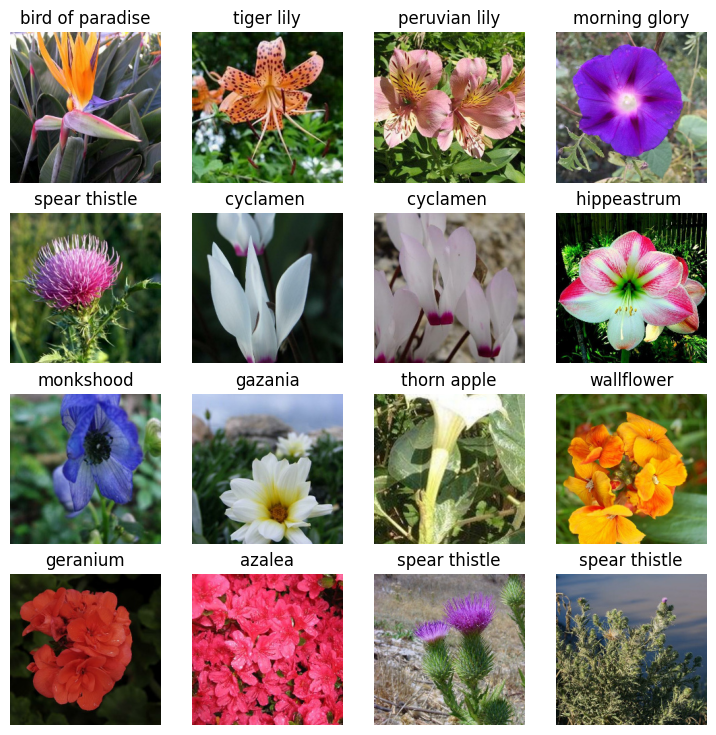

In [397]:
# Plot Data to see what we are working with

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(df_test), size=[1]).item()
    img_id, label, img = df_train.iloc[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(FLOWER_NAMES[label])
    plt.axis(False)

In [398]:
# Setup training and validation steps

# I skip saving intermediate values to memory to leverage operation fusing for faster training. My computer is not very good guys, making this more explicit is expensive and time consuming. 
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):

    model.train()
    train_loss, train_acc, total_samples = 0, 0, 0

    for X, y in dataloader:

        # Calculate predictions / losses of model
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Updating Model Weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += (y_pred.argmax(dim =1 ) == y.argmax(dim=1)).sum().item()
        total_samples += len(y)

    train_loss /= total_samples
    train_acc /= total_samples
    return train_loss , train_acc

# Tracking the accuracy of the model over time with respect to the validation dataset
def valid_step(model:torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):

    model.eval()
    valid_loss, valid_acc, total_samples = 0, 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            valid_loss += loss_fn(y_pred, y).item()
            valid_acc  += (y_pred.argmax(dim =1 ) == y.argmax(dim =1)).sum().item()
            total_samples += len(y)
    valid_loss /= total_samples
    valid_acc /= total_samples
    return valid_loss, valid_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int= 5 ):
    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": [] }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer)
        valid_loss, valid_acc = valid_step(model = model, dataloader = valid_dataloader, loss_fn = loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | valid_loss: {valid_loss:.4f} | valid_acc: {valid_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    return results 
        

In [399]:
# Using the efficientnet b0 model (smallest and thus fastest to train). This won't be the most accurate model due to having less parameters, but I am optimizing for speed of training . 
model = timm.create_model("efficientnet_b0", pretrained= True)
output_shape = len(FLOWER_NAMES) # number of different options being classified 
in_features = model.classifier.in_features

# Freezing base layers, for faster fine-tuning and preventing overfitting
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential (
    nn.Dropout(p=0.3, inplace = True),
    nn.Linear(in_features, output_shape)
)
model.to(device)

# Using class weights to handle unbalanced data, calculated earlier.
loss_fn = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

In [400]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
          Identity-9         [-1, 32, 112, 112]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
    SqueezeExcite-14         [-1, 32, 1

In [401]:
# Train Model
from timeit import default_timer as timer 
torch.manual_seed(42)
num_epochs = 25

start_time = timer()
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        valid_dataloader= validation_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=num_epochs)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

# Epoch: 8 | train_loss: 0.0268 | train_acc: 0.6867 | valid_loss: 0.0395 | valid_acc: 0.6021
#  90%|█████████ | 9/10 [13:14<01:28, 88.27s/it]
# Current Validation accuracy 2358
# Epoch: 9 | train_loss: 0.0258 | train_acc: 0.6853 | valid_loss: 0.0357 | valid_acc: 0.6352
# 100%|██████████| 10/10 [14:43<00:00, 88.39s/it]
# Current Validation accuracy 2283
# Epoch: 10 | train_loss: 0.0256 | train_acc: 0.6844 | valid_loss: 0.0392 | valid_acc: 0.6150
# Total training time: 883.862 seconds


  4%|▍         | 1/25 [01:32<36:56, 92.35s/it]

Epoch: 1 | train_loss: 0.0923 | train_acc: 0.4449 | valid_loss: 0.0650 | valid_acc: 0.5121


  8%|▊         | 2/25 [2:17:26<30:53:11, 4834.40s/it]

Epoch: 2 | train_loss: 0.0493 | train_acc: 0.6027 | valid_loss: 0.0486 | valid_acc: 0.5700


 12%|█▏        | 3/25 [2:19:29<16:23:53, 2683.34s/it]

Epoch: 3 | train_loss: 0.0397 | train_acc: 0.6353 | valid_loss: 0.0449 | valid_acc: 0.5692


 16%|█▌        | 4/25 [2:21:32<9:45:22, 1672.52s/it] 

Epoch: 4 | train_loss: 0.0343 | train_acc: 0.6556 | valid_loss: 0.0449 | valid_acc: 0.5614


 20%|██        | 5/25 [2:23:38<6:11:31, 1114.59s/it]

Epoch: 5 | train_loss: 0.0325 | train_acc: 0.6541 | valid_loss: 0.0413 | valid_acc: 0.5878


 24%|██▍       | 6/25 [2:25:41<4:06:14, 777.60s/it] 

Epoch: 6 | train_loss: 0.0291 | train_acc: 0.6726 | valid_loss: 0.0415 | valid_acc: 0.5929


 28%|██▊       | 7/25 [2:27:44<2:49:06, 563.70s/it]

Epoch: 7 | train_loss: 0.0281 | train_acc: 0.6815 | valid_loss: 0.0389 | valid_acc: 0.6110


 32%|███▏      | 8/25 [2:29:47<1:59:58, 423.44s/it]

Epoch: 8 | train_loss: 0.0268 | train_acc: 0.6884 | valid_loss: 0.0396 | valid_acc: 0.5981


 36%|███▌      | 9/25 [2:31:51<1:27:53, 329.57s/it]

Epoch: 9 | train_loss: 0.0258 | train_acc: 0.6864 | valid_loss: 0.0357 | valid_acc: 0.6331


 40%|████      | 10/25 [2:33:54<1:06:26, 265.79s/it]

Epoch: 10 | train_loss: 0.0256 | train_acc: 0.6830 | valid_loss: 0.0393 | valid_acc: 0.6150


 44%|████▍     | 11/25 [2:35:56<51:48, 222.04s/it]  

Epoch: 11 | train_loss: 0.0244 | train_acc: 0.6949 | valid_loss: 0.0379 | valid_acc: 0.6134


 48%|████▊     | 12/25 [2:37:59<41:32, 191.70s/it]

Epoch: 12 | train_loss: 0.0236 | train_acc: 0.7085 | valid_loss: 0.0366 | valid_acc: 0.6312


 52%|█████▏    | 13/25 [2:40:02<34:11, 170.94s/it]

Epoch: 13 | train_loss: 0.0231 | train_acc: 0.7016 | valid_loss: 0.0347 | valid_acc: 0.6385


 56%|█████▌    | 14/25 [2:42:06<28:44, 156.74s/it]

Epoch: 14 | train_loss: 0.0231 | train_acc: 0.7001 | valid_loss: 0.0410 | valid_acc: 0.5905


 60%|██████    | 15/25 [2:44:09<24:25, 146.55s/it]

Epoch: 15 | train_loss: 0.0229 | train_acc: 0.7031 | valid_loss: 0.0353 | valid_acc: 0.6374


 64%|██████▍   | 16/25 [2:46:11<20:54, 139.39s/it]

Epoch: 16 | train_loss: 0.0227 | train_acc: 0.7077 | valid_loss: 0.0374 | valid_acc: 0.6269


 68%|██████▊   | 17/25 [2:48:17<18:00, 135.07s/it]

Epoch: 17 | train_loss: 0.0224 | train_acc: 0.7055 | valid_loss: 0.0393 | valid_acc: 0.6048


 72%|███████▏  | 18/25 [2:50:56<16:37, 142.49s/it]

Epoch: 18 | train_loss: 0.0216 | train_acc: 0.7066 | valid_loss: 0.0361 | valid_acc: 0.6409


 76%|███████▌  | 19/25 [2:53:00<13:40, 136.78s/it]

Epoch: 19 | train_loss: 0.0215 | train_acc: 0.7080 | valid_loss: 0.0369 | valid_acc: 0.6301


 80%|████████  | 20/25 [2:55:03<11:03, 132.80s/it]

Epoch: 20 | train_loss: 0.0208 | train_acc: 0.7144 | valid_loss: 0.0362 | valid_acc: 0.6398


 84%|████████▍ | 21/25 [2:57:07<08:40, 130.02s/it]

Epoch: 21 | train_loss: 0.0212 | train_acc: 0.7088 | valid_loss: 0.0386 | valid_acc: 0.6142


 88%|████████▊ | 22/25 [2:59:11<06:25, 128.36s/it]

Epoch: 22 | train_loss: 0.0210 | train_acc: 0.7106 | valid_loss: 0.0364 | valid_acc: 0.6355


 92%|█████████▏| 23/25 [3:01:14<04:13, 126.68s/it]

Epoch: 23 | train_loss: 0.0205 | train_acc: 0.7128 | valid_loss: 0.0374 | valid_acc: 0.6334


 96%|█████████▌| 24/25 [3:03:17<02:05, 125.56s/it]

Epoch: 24 | train_loss: 0.0205 | train_acc: 0.7124 | valid_loss: 0.0370 | valid_acc: 0.6261


100%|██████████| 25/25 [3:05:20<00:00, 444.83s/it]

Epoch: 25 | train_loss: 0.0208 | train_acc: 0.7167 | valid_loss: 0.0410 | valid_acc: 0.6021
Total training time: 11120.737 seconds


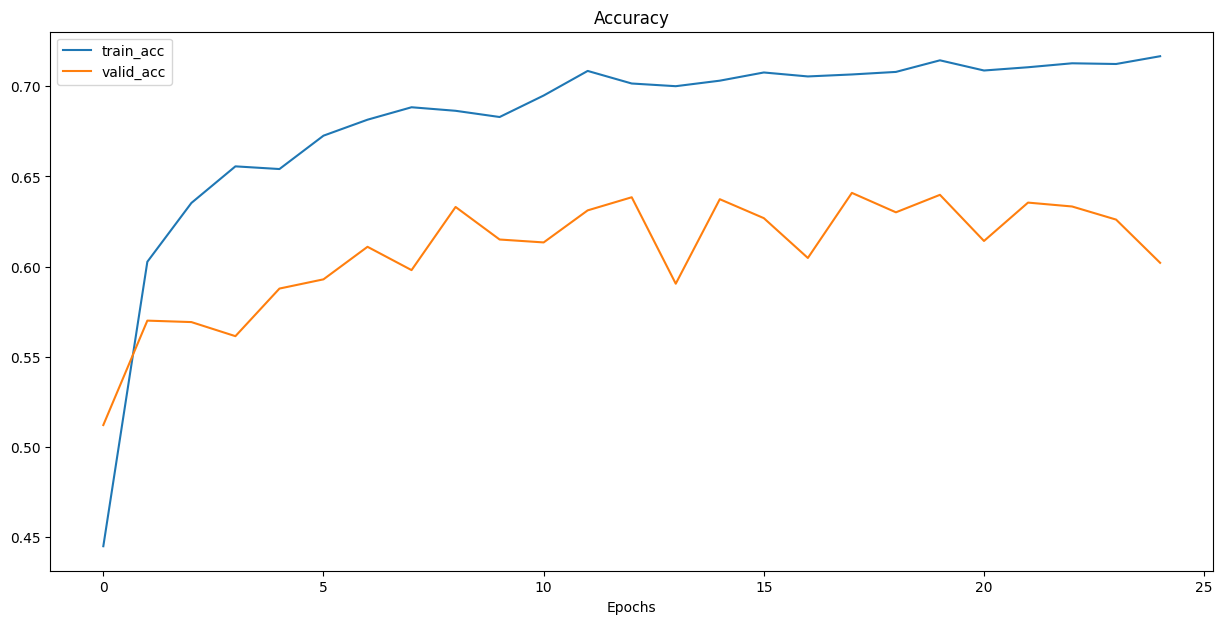

In [403]:
# Plot losses over epochs for training data and test data
plt.figure(figsize=(15, 7))
epochs_range = range(0,25)
# Plot losses over time
plt.plot(epochs_range, [ acc for acc in  model_results['train_acc'] ], label='train_acc')
plt.plot(epochs_range, [ acc for acc in  model_results['valid_acc'] ], label='valid_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()


In [360]:
# Calculate final validation accuracy
model.eval()
validation_acc, total_samples = 0, 0
with torch.inference_mode():
    for X, y in validation_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X).argmax(dim =1 )
        # print(f"validation pred index {validation_pred_index}")
        # print(f"Length y {len(y)} and length of validation_pred_index {len(validation_pred_index)}")
        validation_acc += (y_pred == y.argmax(dim =1)).sum().item()
        total_samples += len(y)
validation_acc /= total_samples
print(f"Valid Accuracy {round(validation_acc * 100,2)}")
# Epochs = 20 -> 63.28 % , lR = 0.01 
# Epochs = 40 -> 69.02 % , lr = 0.01 

# Epochs = 20 -> 62.98 %, lr = 0.01
# Epochs = 20 -> 68.32 %, lr = 0.001 
# Epochs =20 -> 64.01 %, lr = 0.001 -> using weighted loss function

# Epochs = 10 -> 61.6 %, lr = 0.001

Valid Accuracy 61.5


I'm still not finished optimizing, but working on other projects and don't have time atm. 